In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 2

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 1., 1000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.000289411670; False Transient Error: 0.000001161700; Iterations: 584; CG Error: 0.000000000098
Episode 957: PDE Error: 0.002042111889; False Transient Error: 0.000000995661; Iterations: 697; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.016472298678; False Transient Error: 0.000002347391; Iterations: 778; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.006265141508; False Transient Error: 0.000001631688; Iterations: 781; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.032310887478; False Transient Error: 0.000002476669; Iterations: 758; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.038141265845; False Transient Error: 0.000002397040; Iterations: 747; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.028391879423; False Transient Error: 0.000002499763; Iterations: 775; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.024443394645; False Transient Error: 0.000002491579; Iterations: 783; CG Error: 0.000000000099
Episode 1000: PDE Error: 

In [6]:
np.save("v_list_2", ϕ_list)
np.save("e_list_2", ems_list)

In [6]:
ϕ_list = np.load("v_list_2.npy")
ems_list = np.load("e_list_2.npy")

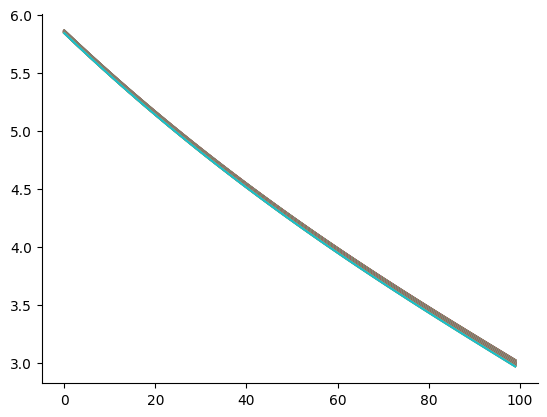

In [7]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

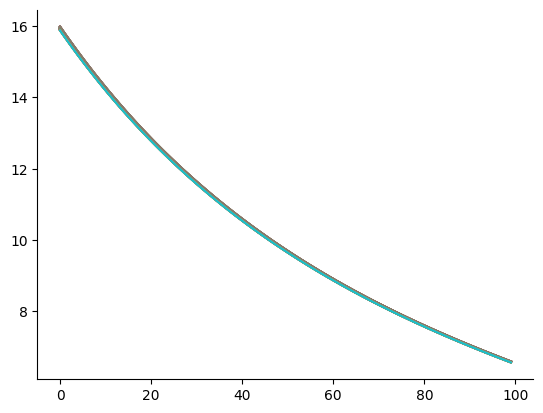

In [8]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [9]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.554351386822	 rhs error: 0.558783985852
Episode: 2	 lhs error: 0.539857624311	 rhs error: 0.545165054432
Episode: 3	 lhs error: 0.520697618666	 rhs error: 0.525392835876
Episode: 4	 lhs error: 0.498771964266	 rhs error: 0.503052510235
Episode: 5	 lhs error: 0.475942584599	 rhs error: 0.479627609396
Episode: 6	 lhs error: 0.452597110848	 rhs error: 0.455848979517
Episode: 7	 lhs error: 0.429153239607	 rhs error: 0.432154072801
Episode: 8	 lhs error: 0.406134345029	 rhs error: 0.408798070762
Episode: 9	 lhs error: 0.383802471421	 rhs error: 0.385926372256
Episode: 10	 lhs error: 0.362074245699	 rhs error: 0.363643912828
Episode: 11	 lhs error: 0.340869782972	 rhs error: 0.342044583894
Episode: 12	 lhs error: 0.320244992172	 rhs error: 0.321205076560
Episode: 13	 lhs error: 0.300414538967	 rhs error: 0.301169405922
Episode: 14	 lhs error: 0.281755549105	 rhs error: 0.281929915411
Episode: 15	 lhs error: 0.263423343535	 rhs error: 0.263511261445
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.042212522852	 rhs error: 0.134651699031
Episode: 126	 lhs error: 0.042052879227	 rhs error: 0.134859438401
Episode: 127	 lhs error: 0.042127615412	 rhs error: 0.135060135991
Episode: 128	 lhs error: 0.041872484413	 rhs error: 0.135270288538
Episode: 129	 lhs error: 0.041745919869	 rhs error: 0.135469879865
Episode: 130	 lhs error: 0.041441308737	 rhs error: 0.135663094982
Episode: 131	 lhs error: 0.041328009837	 rhs error: 0.135837590960
Episode: 132	 lhs error: 0.041169968623	 rhs error: 0.136008817451
Episode: 133	 lhs error: 0.041002532043	 rhs error: 0.136174084511
Episode: 134	 lhs error: 0.041002997775	 rhs error: 0.136331839284
Episode: 135	 lhs error: 0.040760664406	 rhs error: 0.136493969481
Episode: 136	 lhs error: 0.040591767613	 rhs error: 0.136644788476
Episode: 137	 lhs error: 0.040438928911	 rhs error: 0.136787215381
Episode: 138	 lhs error: 0.040290169699	 rhs error: 0.136923253333
Episode: 139	 lhs error: 0.040142377057	 rhs error: 0.13705331

Episode: 249	 lhs error: 0.028786110077	 rhs error: 0.145295023445
Episode: 250	 lhs error: 0.028700727811	 rhs error: 0.145215678686
Episode: 251	 lhs error: 0.028614570422	 rhs error: 0.145128130334
Episode: 252	 lhs error: 0.028527902980	 rhs error: 0.145032372623
Episode: 253	 lhs error: 0.028440470344	 rhs error: 0.144928433400
Episode: 254	 lhs error: 0.028352384281	 rhs error: 0.144816312137
Episode: 255	 lhs error: 0.028263774133	 rhs error: 0.144696019944
Episode: 256	 lhs error: 0.028174419794	 rhs error: 0.144567590125
Episode: 257	 lhs error: 0.028084554825	 rhs error: 0.144431029102
Episode: 258	 lhs error: 0.027993963312	 rhs error: 0.144286373463
Episode: 259	 lhs error: 0.027902705838	 rhs error: 0.144133635918
Episode: 260	 lhs error: 0.027810894278	 rhs error: 0.143972835273
Episode: 261	 lhs error: 0.027718369391	 rhs error: 0.143804010952
Episode: 262	 lhs error: 0.027625250797	 rhs error: 0.143627181484
Episode: 263	 lhs error: 0.027531559538	 rhs error: 0.14344238

Episode: 373	 lhs error: 0.022001950069	 rhs error: 0.091228833712
Episode: 374	 lhs error: 0.021968990989	 rhs error: 0.090661525123
Episode: 375	 lhs error: 0.021936417141	 rhs error: 0.090095903344
Episode: 376	 lhs error: 0.021903037769	 rhs error: 0.089532212967
Episode: 377	 lhs error: 0.021869159468	 rhs error: 0.088970430549
Episode: 378	 lhs error: 0.021835152624	 rhs error: 0.088410611487
Episode: 379	 lhs error: 0.021799939501	 rhs error: 0.087852882238
Episode: 380	 lhs error: 0.021765810707	 rhs error: 0.087297148987
Episode: 381	 lhs error: 0.021729164789	 rhs error: 0.086743783963
Episode: 382	 lhs error: 0.021693533755	 rhs error: 0.086192421100
Episode: 383	 lhs error: 0.021657131541	 rhs error: 0.085643425846
Episode: 384	 lhs error: 0.021619676327	 rhs error: 0.085096785689
Episode: 385	 lhs error: 0.021583893870	 rhs error: 0.084552432299
Episode: 386	 lhs error: 0.021544151151	 rhs error: 0.084010844142
Episode: 387	 lhs error: 0.021507344951	 rhs error: 0.08347136

Episode: 497	 lhs error: 0.017591660574	 rhs error: 0.044734432645
Episode: 498	 lhs error: 0.017520695268	 rhs error: 0.044398964826
Episode: 499	 lhs error: 0.017551680947	 rhs error: 0.044054711713
Episode: 500	 lhs error: 0.017485537065	 rhs error: 0.043723853830
Episode: 501	 lhs error: 0.017453387739	 rhs error: 0.043385362698
Episode: 502	 lhs error: 0.017437613558	 rhs error: 0.043047139054
Episode: 503	 lhs error: 0.017422338033	 rhs error: 0.042756009714
Episode: 504	 lhs error: 0.017406542538	 rhs error: 0.042577504900
Episode: 505	 lhs error: 0.017390843646	 rhs error: 0.042403124081
Episode: 506	 lhs error: 0.017372747037	 rhs error: 0.042232764949
Episode: 507	 lhs error: 0.017353778568	 rhs error: 0.042065710879
Episode: 508	 lhs error: 0.017327440069	 rhs error: 0.041901688788
Episode: 509	 lhs error: 0.017304644556	 rhs error: 0.041739039318
Episode: 510	 lhs error: 0.017281247272	 rhs error: 0.041578670428
Episode: 511	 lhs error: 0.017255651903	 rhs error: 0.04142044

Episode: 621	 lhs error: 0.014524321226	 rhs error: 0.032661174150
Episode: 622	 lhs error: 0.014506708959	 rhs error: 0.032629622558
Episode: 623	 lhs error: 0.014493120277	 rhs error: 0.032608694782
Episode: 624	 lhs error: 0.014423164520	 rhs error: 0.032581344171
Episode: 625	 lhs error: 0.014427781405	 rhs error: 0.032534605274
Episode: 626	 lhs error: 0.014386578129	 rhs error: 0.032499699708
Episode: 627	 lhs error: 0.014404956610	 rhs error: 0.032470726010
Episode: 628	 lhs error: 0.014396360226	 rhs error: 0.032436236705
Episode: 629	 lhs error: 0.014358528625	 rhs error: 0.032410682192
Episode: 630	 lhs error: 0.014294324975	 rhs error: 0.032391754641
Episode: 631	 lhs error: 0.014305358090	 rhs error: 0.032345510015
Episode: 632	 lhs error: 0.014299762727	 rhs error: 0.032321342436
Episode: 633	 lhs error: 0.014274808293	 rhs error: 0.032298667557
Episode: 634	 lhs error: 0.014265906795	 rhs error: 0.032295776376
Episode: 635	 lhs error: 0.014228205103	 rhs error: 0.03229678

Episode: 745	 lhs error: 0.012141424471	 rhs error: 0.032174637763
Episode: 746	 lhs error: 0.012122803928	 rhs error: 0.032174426993
Episode: 747	 lhs error: 0.012104239552	 rhs error: 0.032174274347
Episode: 748	 lhs error: 0.012086544686	 rhs error: 0.032174285458
Episode: 749	 lhs error: 0.012066510126	 rhs error: 0.032174697751
Episode: 750	 lhs error: 0.012048663570	 rhs error: 0.032174853444
Episode: 751	 lhs error: 0.012028178434	 rhs error: 0.032175480086
Episode: 752	 lhs error: 0.012007860306	 rhs error: 0.032175777448
Episode: 753	 lhs error: 0.011986162151	 rhs error: 0.032175892481
Episode: 754	 lhs error: 0.011966167865	 rhs error: 0.032175503210
Episode: 755	 lhs error: 0.011947864299	 rhs error: 0.032175167858
Episode: 756	 lhs error: 0.011924590079	 rhs error: 0.032175474384
Episode: 757	 lhs error: 0.011904620371	 rhs error: 0.032174946024
Episode: 758	 lhs error: 0.011884618975	 rhs error: 0.032174665368
Episode: 759	 lhs error: 0.011862663491	 rhs error: 0.03217466

Episode: 869	 lhs error: 0.010245644523	 rhs error: 0.032079494001
Episode: 870	 lhs error: 0.010234450229	 rhs error: 0.032078186676
Episode: 871	 lhs error: 0.010220996625	 rhs error: 0.032077592642
Episode: 872	 lhs error: 0.010207369706	 rhs error: 0.032076854505
Episode: 873	 lhs error: 0.010194717744	 rhs error: 0.032075955084
Episode: 874	 lhs error: 0.010181866374	 rhs error: 0.032075334219
Episode: 875	 lhs error: 0.010166414964	 rhs error: 0.032074955841
Episode: 876	 lhs error: 0.010153035481	 rhs error: 0.032073848659
Episode: 877	 lhs error: 0.010140397763	 rhs error: 0.032072913989
Episode: 878	 lhs error: 0.010126255458	 rhs error: 0.032072503430
Episode: 879	 lhs error: 0.010111141734	 rhs error: 0.032071990163
Episode: 880	 lhs error: 0.010099201251	 rhs error: 0.032071085555
Episode: 881	 lhs error: 0.010084317028	 rhs error: 0.032071124566
Episode: 882	 lhs error: 0.010070633598	 rhs error: 0.032070884594
Episode: 883	 lhs error: 0.010055253500	 rhs error: 0.03207094

Episode: 993	 lhs error: 0.008727627669	 rhs error: 0.032083571378
Episode: 994	 lhs error: 0.008716896320	 rhs error: 0.032083737186
Episode: 995	 lhs error: 0.008706051913	 rhs error: 0.032083936705
Episode: 996	 lhs error: 0.008695112195	 rhs error: 0.032084158663
Episode: 997	 lhs error: 0.008684367889	 rhs error: 0.032084402211
Episode: 998	 lhs error: 0.008673178834	 rhs error: 0.032084837708
Episode: 999	 lhs error: 0.008662118729	 rhs error: 0.032085258237
Episode: 1000	 lhs error: 0.008650555447	 rhs error: 0.032085781772
Episode: 1001	 lhs error: 0.008639085350	 rhs error: 0.032086194379
Episode: 1002	 lhs error: 0.008627160386	 rhs error: 0.032086601158
Episode: 1003	 lhs error: 0.008615514479	 rhs error: 0.032086823348
Episode: 1004	 lhs error: 0.008603979478	 rhs error: 0.032087063533
Episode: 1005	 lhs error: 0.008592329985	 rhs error: 0.032087455889
Episode: 1006	 lhs error: 0.008580202111	 rhs error: 0.032087986772
Episode: 1007	 lhs error: 0.008568143096	 rhs error: 0.

Episode: 1117	 lhs error: 0.007473779190	 rhs error: 0.032103457315
Episode: 1118	 lhs error: 0.007463390958	 rhs error: 0.032103726567
Episode: 1119	 lhs error: 0.007453049116	 rhs error: 0.032103936328
Episode: 1120	 lhs error: 0.007442483965	 rhs error: 0.032104218215
Episode: 1121	 lhs error: 0.007431952471	 rhs error: 0.032104432100
Episode: 1122	 lhs error: 0.007421268879	 rhs error: 0.032104699030
Episode: 1123	 lhs error: 0.007412837184	 rhs error: 0.032104951153
Episode: 1124	 lhs error: 0.007405258975	 rhs error: 0.032105165843
Episode: 1125	 lhs error: 0.007397627395	 rhs error: 0.032105370820
Episode: 1126	 lhs error: 0.007389880270	 rhs error: 0.032105593512
Episode: 1127	 lhs error: 0.007382040165	 rhs error: 0.032105787920
Episode: 1128	 lhs error: 0.007374125125	 rhs error: 0.032105937996
Episode: 1129	 lhs error: 0.007366177130	 rhs error: 0.032106050948
Episode: 1130	 lhs error: 0.007358156908	 rhs error: 0.032106182470
Episode: 1131	 lhs error: 0.007350029385	 rhs er

Episode: 1241	 lhs error: 0.006441850122	 rhs error: 0.032118154180
Episode: 1242	 lhs error: 0.006432947705	 rhs error: 0.032120062983
Episode: 1243	 lhs error: 0.006424634684	 rhs error: 0.032119392957
Episode: 1244	 lhs error: 0.006416484576	 rhs error: 0.032118212239
Episode: 1245	 lhs error: 0.006408226158	 rhs error: 0.032117022208
Episode: 1246	 lhs error: 0.006399899850	 rhs error: 0.032115589390
Episode: 1247	 lhs error: 0.006391564510	 rhs error: 0.032113866083
Episode: 1248	 lhs error: 0.006383202999	 rhs error: 0.032111973792
Episode: 1249	 lhs error: 0.006374799879	 rhs error: 0.032109986735
Episode: 1250	 lhs error: 0.006366320723	 rhs error: 0.032107995168
Episode: 1251	 lhs error: 0.006357784305	 rhs error: 0.032105974260
Episode: 1252	 lhs error: 0.006351038862	 rhs error: 0.032103997226
Episode: 1253	 lhs error: 0.006344577992	 rhs error: 0.032102030159
Episode: 1254	 lhs error: 0.006338158891	 rhs error: 0.032100144041
Episode: 1255	 lhs error: 0.006331709111	 rhs er

Episode: 1365	 lhs error: 0.005564073853	 rhs error: 0.032132625425
Episode: 1366	 lhs error: 0.005556805312	 rhs error: 0.032133173038
Episode: 1367	 lhs error: 0.005549472364	 rhs error: 0.032133719525
Episode: 1368	 lhs error: 0.005542914645	 rhs error: 0.032134277767
Episode: 1369	 lhs error: 0.005537230273	 rhs error: 0.032134865702
Episode: 1370	 lhs error: 0.005531454442	 rhs error: 0.032135411774
Episode: 1371	 lhs error: 0.005525595021	 rhs error: 0.032135984356
Episode: 1372	 lhs error: 0.005519691692	 rhs error: 0.032136630321
Episode: 1373	 lhs error: 0.005513835169	 rhs error: 0.032137317927
Episode: 1374	 lhs error: 0.005507766616	 rhs error: 0.032137868895
Episode: 1375	 lhs error: 0.005501758176	 rhs error: 0.032138577936
Episode: 1376	 lhs error: 0.005495645897	 rhs error: 0.032139224722
Episode: 1377	 lhs error: 0.005489495871	 rhs error: 0.032139901990
Episode: 1378	 lhs error: 0.005483284063	 rhs error: 0.032140578263
Episode: 1379	 lhs error: 0.005477002441	 rhs er

Episode: 1489	 lhs error: 0.004828093934	 rhs error: 0.032097301102
Episode: 1490	 lhs error: 0.004822985023	 rhs error: 0.032104066371
Episode: 1491	 lhs error: 0.004817999122	 rhs error: 0.032107936398
Episode: 1492	 lhs error: 0.004812498012	 rhs error: 0.032110390290
Episode: 1493	 lhs error: 0.004840387894	 rhs error: 0.032112224130
Episode: 1494	 lhs error: 0.004810274374	 rhs error: 0.032094374145
Episode: 1495	 lhs error: 0.004793138458	 rhs error: 0.032091407871
Episode: 1496	 lhs error: 0.004785956852	 rhs error: 0.032098827811
Episode: 1497	 lhs error: 0.004781509523	 rhs error: 0.032104807145
Episode: 1498	 lhs error: 0.004777315744	 rhs error: 0.032108097611
Episode: 1499	 lhs error: 0.004789633872	 rhs error: 0.032110437210
Episode: 1500	 lhs error: 0.004778129451	 rhs error: 0.032099726703
Episode: 1501	 lhs error: 0.004755755349	 rhs error: 0.032095918617
Episode: 1502	 lhs error: 0.004749553182	 rhs error: 0.032106597309
Episode: 1503	 lhs error: 0.004748780121	 rhs er

Episode: 1613	 lhs error: 0.004211636952	 rhs error: 0.032104218365
Episode: 1614	 lhs error: 0.004206925985	 rhs error: 0.032099619833
Episode: 1615	 lhs error: 0.004202363943	 rhs error: 0.032096197302
Episode: 1616	 lhs error: 0.004198064222	 rhs error: 0.032093568176
Episode: 1617	 lhs error: 0.004193715973	 rhs error: 0.032091407437
Episode: 1618	 lhs error: 0.004189215439	 rhs error: 0.032089637938
Episode: 1619	 lhs error: 0.004184646031	 rhs error: 0.032088255213
Episode: 1620	 lhs error: 0.004180002524	 rhs error: 0.032087205797
Episode: 1621	 lhs error: 0.004175338200	 rhs error: 0.032086455755
Episode: 1622	 lhs error: 0.004170634180	 rhs error: 0.032085948092
Episode: 1623	 lhs error: 0.004165908763	 rhs error: 0.032085646081
Episode: 1624	 lhs error: 0.004161147593	 rhs error: 0.032085504844
Episode: 1625	 lhs error: 0.004156344549	 rhs error: 0.032085496143
Episode: 1626	 lhs error: 0.004151498689	 rhs error: 0.032085600241
Episode: 1627	 lhs error: 0.004146623423	 rhs er

Episode: 1737	 lhs error: 0.003568755875	 rhs error: 0.032113131823
Episode: 1738	 lhs error: 0.003561983774	 rhs error: 0.032112951561
Episode: 1739	 lhs error: 0.003555720669	 rhs error: 0.032112699556
Episode: 1740	 lhs error: 0.003559629564	 rhs error: 0.032112002403
Episode: 1741	 lhs error: 0.003534553912	 rhs error: 0.032105758266
Episode: 1742	 lhs error: 0.003532434185	 rhs error: 0.032114926788
Episode: 1743	 lhs error: 0.003525214040	 rhs error: 0.032115213379
Episode: 1744	 lhs error: 0.003518654419	 rhs error: 0.032115289360
Episode: 1745	 lhs error: 0.003511243571	 rhs error: 0.032115329373
Episode: 1746	 lhs error: 0.003504293223	 rhs error: 0.032115461079
Episode: 1747	 lhs error: 0.003498223418	 rhs error: 0.032115356564
Episode: 1748	 lhs error: 0.003504520561	 rhs error: 0.032114475555
Episode: 1749	 lhs error: 0.003477152616	 rhs error: 0.032106851835
Episode: 1750	 lhs error: 0.003474113796	 rhs error: 0.032117364591
Episode: 1751	 lhs error: 0.003466437393	 rhs er

Episode: 1861	 lhs error: 0.002482163186	 rhs error: 0.032146370567
Episode: 1862	 lhs error: 0.002472061101	 rhs error: 0.032146615758
Episode: 1863	 lhs error: 0.002462013568	 rhs error: 0.032146961275
Episode: 1864	 lhs error: 0.002473747128	 rhs error: 0.032147232039
Episode: 1865	 lhs error: 0.002469503974	 rhs error: 0.032138097912
Episode: 1866	 lhs error: 0.002429700160	 rhs error: 0.032134252181
Episode: 1867	 lhs error: 0.002415639524	 rhs error: 0.032145128202
Episode: 1868	 lhs error: 0.002406469473	 rhs error: 0.032149559398
Episode: 1869	 lhs error: 0.002427426949	 rhs error: 0.032151695161
Episode: 1870	 lhs error: 0.002424505318	 rhs error: 0.032140834646
Episode: 1871	 lhs error: 0.002371001391	 rhs error: 0.032135726276
Episode: 1872	 lhs error: 0.002415413666	 rhs error: 0.032146848158
Episode: 1873	 lhs error: 0.002386069958	 rhs error: 0.032140637733
Episode: 1874	 lhs error: 0.002366758063	 rhs error: 0.032134022132
Episode: 1875	 lhs error: 0.002352772277	 rhs er

Episode: 1985	 lhs error: 0.001309945295	 rhs error: 0.032124030789
Episode: 1986	 lhs error: 0.001301558861	 rhs error: 0.032124892093
Episode: 1987	 lhs error: 0.001293191755	 rhs error: 0.032125754147
Episode: 1988	 lhs error: 0.001284878402	 rhs error: 0.032126599742
Episode: 1989	 lhs error: 0.001276574970	 rhs error: 0.032127429021
Episode: 1990	 lhs error: 0.001268291647	 rhs error: 0.032128272467
Episode: 1991	 lhs error: 0.001260046834	 rhs error: 0.032129121462
Episode: 1992	 lhs error: 0.001251858846	 rhs error: 0.032129961118
Episode: 1993	 lhs error: 0.001243692611	 rhs error: 0.032130772425
Episode: 1994	 lhs error: 0.001235539831	 rhs error: 0.032131593208
Episode: 1995	 lhs error: 0.001227424020	 rhs error: 0.032132413681
Episode: 1996	 lhs error: 0.001219374007	 rhs error: 0.032133216432
Episode: 1997	 lhs error: 0.001211372486	 rhs error: 0.032133984973
Episode: 1998	 lhs error: 0.001203377004	 rhs error: 0.032134758670
Episode: 1999	 lhs error: 0.001195392512	 rhs er

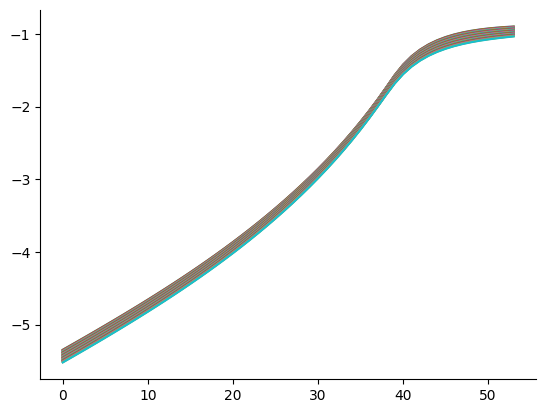

In [26]:
plt.plot((v_m  - v0)[-1])
plt.show()

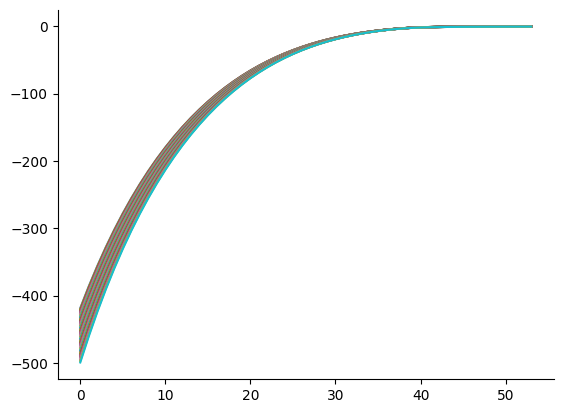

In [18]:
distort_inten =  np.sum(πd_o * g_m * (v_m - v0), axis=0)
# np.save(f"inten_multi_{λ}", distort_inten)
plt.plot(distort_inten)
plt.show()

In [58]:
np.save(f"ems_{λ}", ems)
np.save(f"v_{λ}", v0)

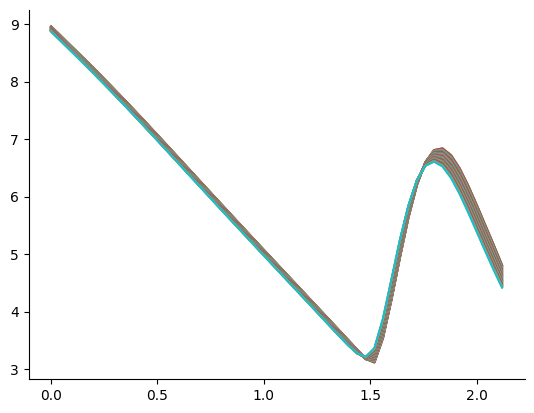

In [10]:
plt.plot(y1_grid_cap, ems)
plt.show()

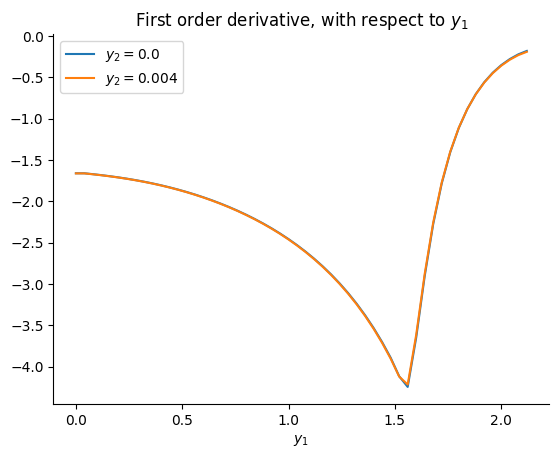

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

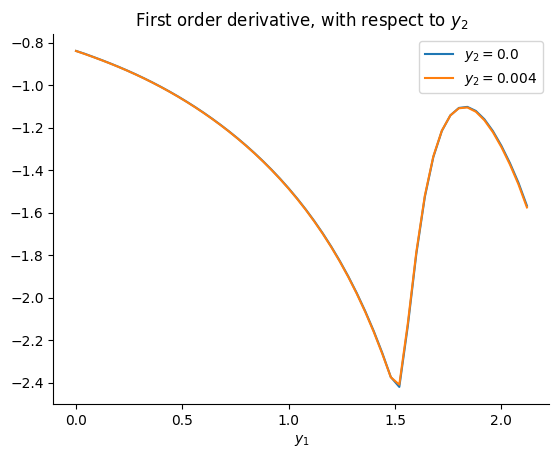

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

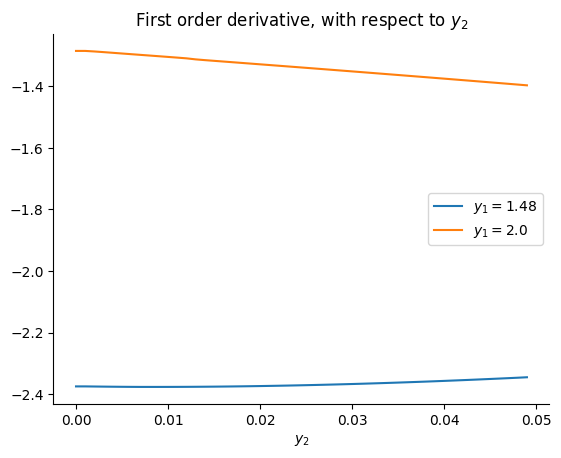

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

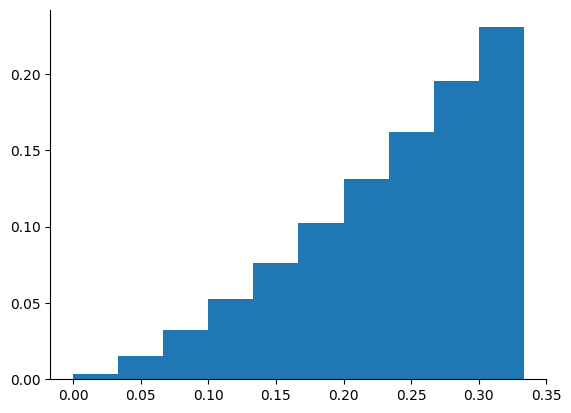

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

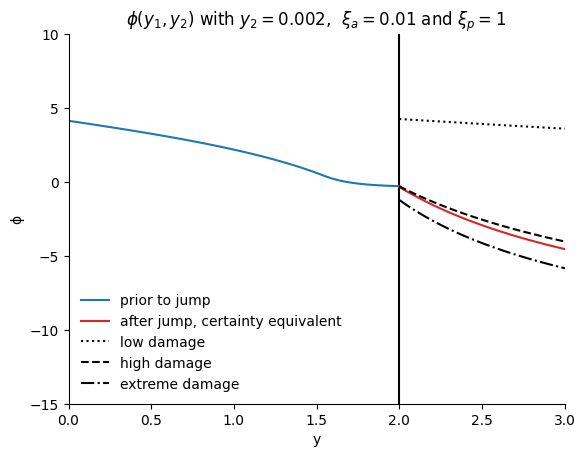

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

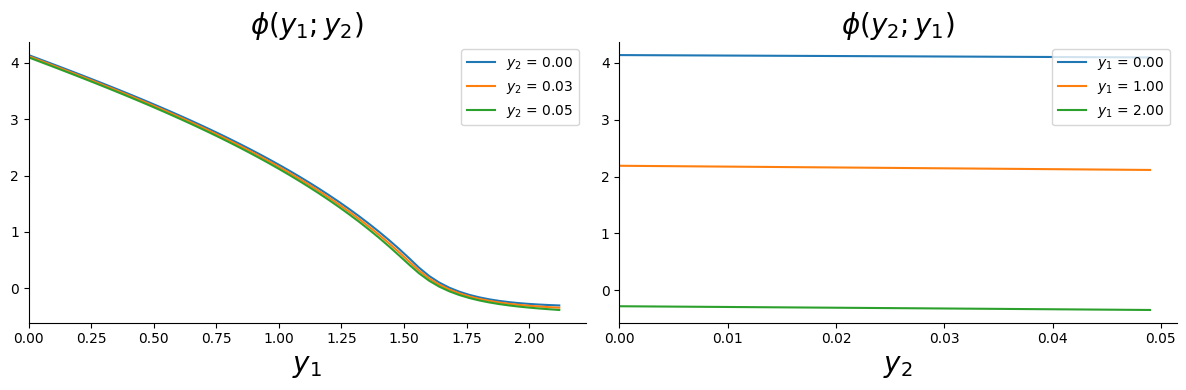

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

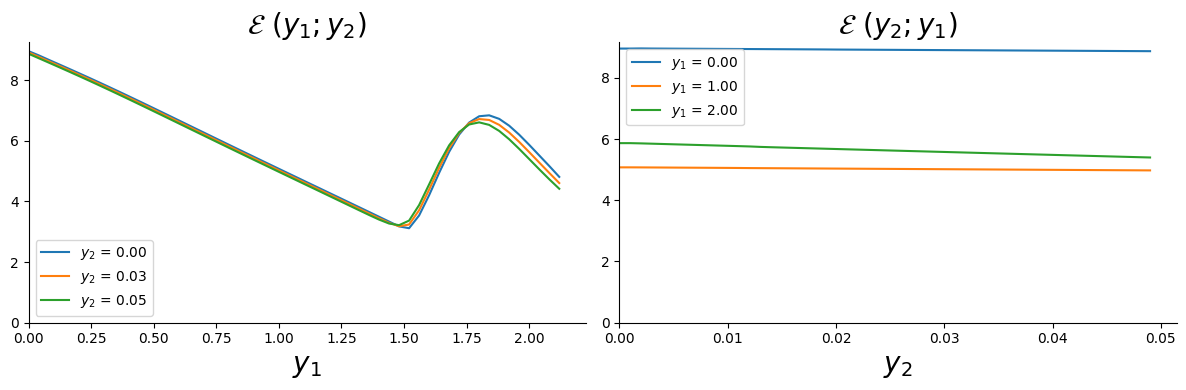

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

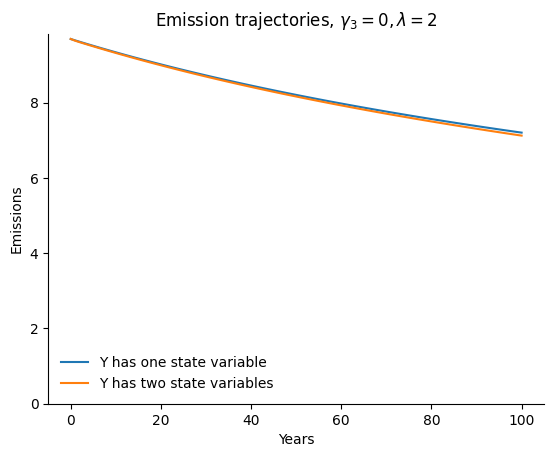

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [44]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [46]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

In [47]:
y1t_prejump

array([1.1       , 1.10778465, 1.11630198, 1.12486182, 1.13337288,
       1.14182344, 1.15021235, 1.15853984, 1.16680635, 1.17501235,
       1.18315829, 1.19124462, 1.19927176, 1.20724014, 1.2151501 ,
       1.22300204, 1.23079639, 1.23853358, 1.24621401, 1.25383811,
       1.26140628, 1.26891893, 1.27637647, 1.28377931, 1.29112785,
       1.29842248, 1.3056636 , 1.31285159, 1.31998684, 1.32706974,
       1.33410054, 1.34107959, 1.3480073 , 1.35488404, 1.36171017,
       1.36848607, 1.37521211, 1.38188863, 1.38851602, 1.39509463,
       1.40162482, 1.40810699, 1.41454161, 1.42092903, 1.4272696 ,
       1.43356365, 1.43981152, 1.44601353, 1.45217175, 1.45828671,
       1.46435873, 1.47038807, 1.47637499, 1.48231974, 1.4882334 ,
       1.4941343 , 1.50002491, 1.50590557, 1.51177631, 1.51763713,
       1.52348801, 1.52939438, 1.53541096, 1.54154764, 1.54780812,
       1.55419519, 1.56071155, 1.56736681, 1.57422201, 1.58129156,
       1.58858345, 1.59610493, 1.60386311, 1.61187521, 1.62016

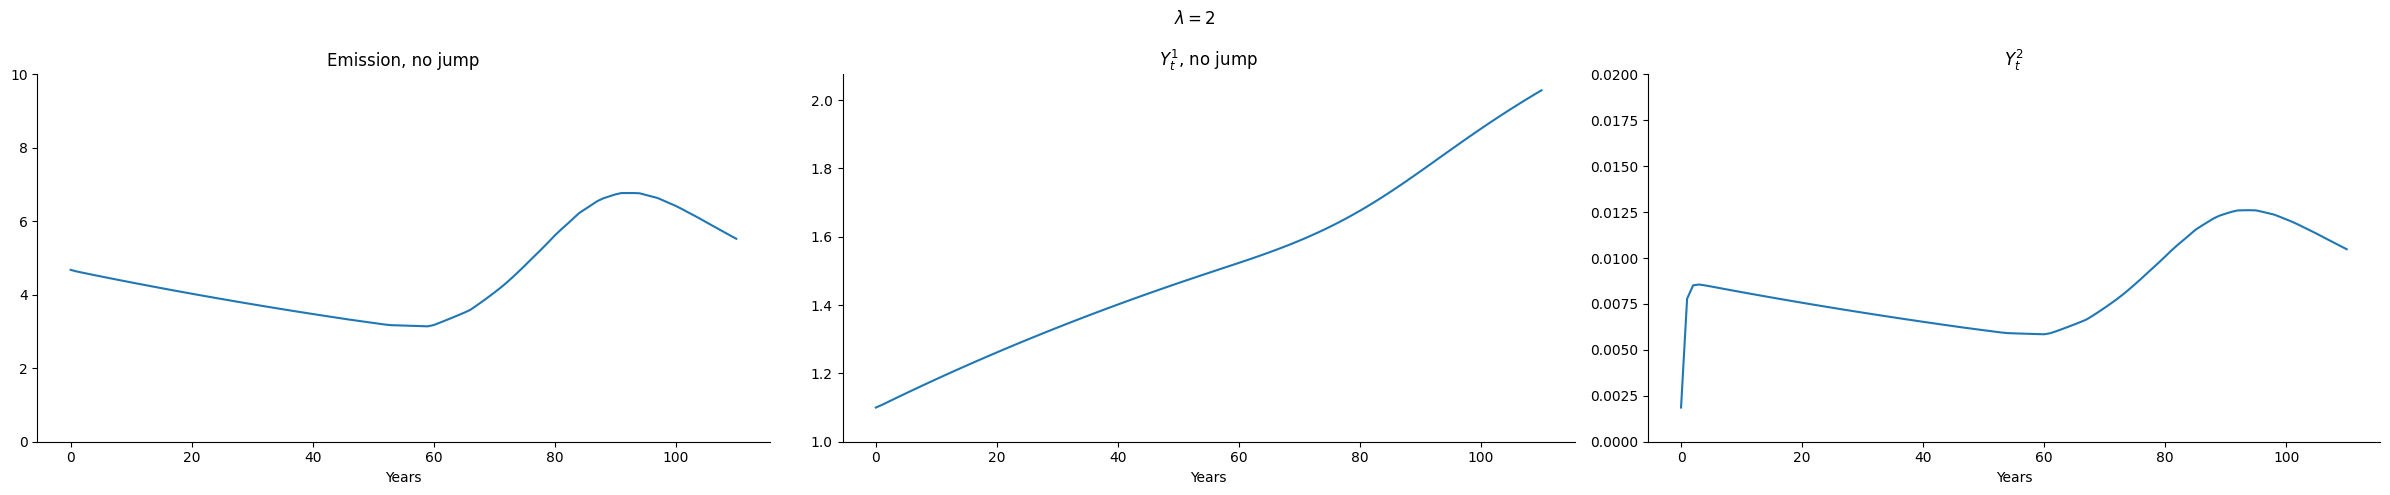

In [48]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [41]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

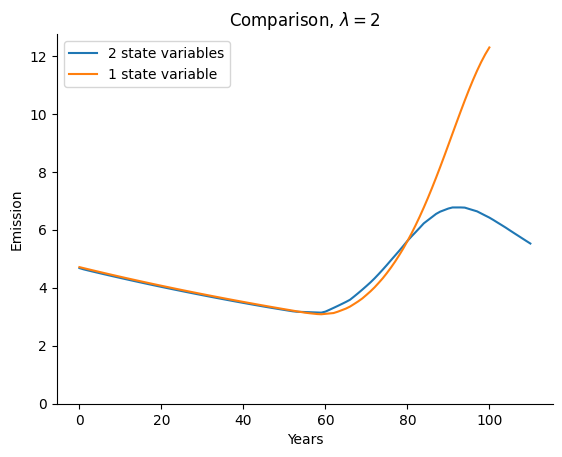

In [49]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

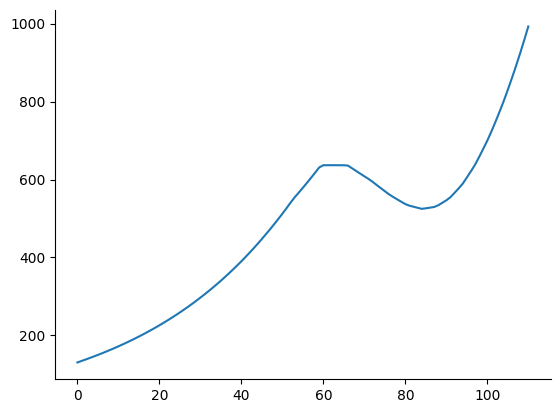

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)